In [116]:
import numpy as np
import cv2
import sudoku 
import homography

from pylab import *
from matplotlib import pyplot as plt
from model import Model
%matplotlib inline

Loading image to work on and model

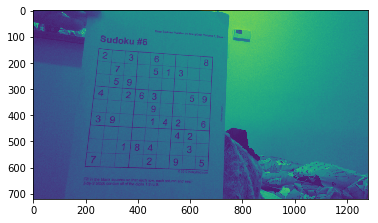

In [117]:
image = cv2.imread('img.jpg',0)
model = Model()
model.load("./model.h5")

plt.figure()
plt.imshow(image)

Transforming image

0.001289844


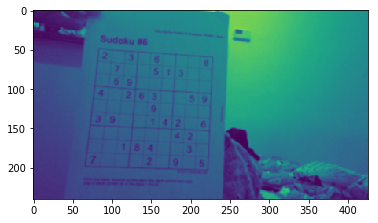

In [118]:
e1 = cv2.getTickCount()

height, width = image.shape
orig = cv2.resize(image, (width // 3, height // 3))
kernel_val = 11 // 3 if (11 // 3) % 2 == 1 else (11 // 3) + 1
blur = cv2.GaussianBlur(orig,(kernel_val, kernel_val),0)
kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kernel_val, kernel_val))

e2 = cv2.getTickCount()
time = (e2 - e1)/ cv2.getTickFrequency()

print(time)
plt.figure()
plt.imshow(blur)

0.001114826


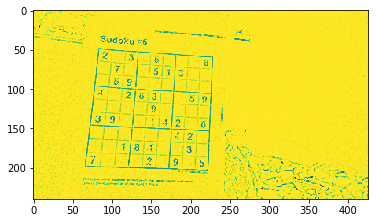

In [119]:
e1 = cv2.getTickCount()

# perform a morphology based on the previously computed kernel
close = cv2.morphologyEx(blur,cv2.MORPH_CLOSE,kernel1)
div = np.float32(blur)/(close)
res = np.uint8(cv2.normalize(div,div,0,255,cv2.NORM_MINMAX))

e2 = cv2.getTickCount()
time = (e2 - e1)/ cv2.getTickFrequency()

print(time)
plt.figure()
plt.imshow(res)

Looking for contour in image

0.013708067


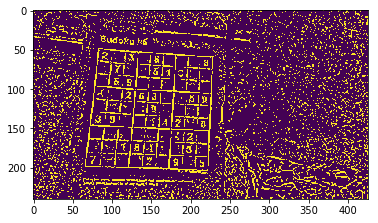

In [120]:
e1 = cv2.getTickCount()

thresh = cv2.adaptiveThreshold(res,255,0,1,19,2)
ind, contours,hier = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

e2 = cv2.getTickCount()
time = (e2 - e1)/ cv2.getTickFrequency()

print(time)
plt.figure()
plt.imshow(thresh)

In [121]:
e1 = cv2.getTickCount()

# find the sudoku gameboard by looking for the largest square in image
biggest = None
max_area = 0
for i in contours:
    area = cv2.contourArea(i)
    if area > (10000 / (3 ** 2)):
        peri = cv2.arcLength(i,True)
        approx = cv2.approxPolyDP(i,0.02*peri,True)
        if area > max_area and len(approx)==4:
            biggest = approx
            max_area = area        

# calculate the center of the square
try:
    M = cv2.moments(biggest)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
except:
    print("Whoops")

# find the location of the four corners
for a in range(0, 4):
    # calculate the difference between the center 
    # of the square and the current point
    dx = biggest[a][0][0] - cx
    dy = biggest[a][0][1] - cy

    if dx < 0 and dy < 0:
        topleft = (biggest[a][0][0] * 3, biggest[a][0][1] * 3)
    elif dx > 0 and dy < 0:
        topright = (biggest[a][0][0] * 3, biggest[a][0][1] * 3)
    elif dx > 0 and dy > 0:
        botright = (biggest[a][0][0] * 3, biggest[a][0][1] * 3)
    elif dx < 0 and dy > 0:
        botleft = (biggest[a][0][0] * 3, biggest[a][0][1] * 3)

# the four corners from top left going clockwise
try:
    corners = []
    corners.append(topleft)
    corners.append(topright)
    corners.append(botright)
    corners.append(botleft)
except:
    print("Whoops")
    
    
e2 = cv2.getTickCount()
time = (e2 - e1)/ cv2.getTickFrequency()

print(time)
print(corners)

0.004098213
[(249, 144), (687, 174), (666, 609), (195, 597)]


Shrinking image so it contains only sudoku

0.003065064


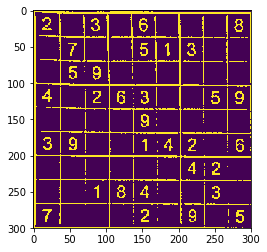

In [122]:
def perform_homography(x):
    fp = array([array([p[1],p[0],1]) for p in x]).T
    tp = array([[0,0,1],[0,300,1],[300,300,1],[300,0,1]]).T
    # estimate the homography
    H = homography.H_from_points(tp,fp)
    
    
e1 = cv2.getTickCount()

perform_homography(corners)
res_size = np.float32([[0,0],[300,0],[300,300],[0,300]])
M = cv2.getPerspectiveTransform(np.float32(corners),res_size)
sudoku = cv2.warpPerspective(image,M,(300,300))
sudoku = cv2.adaptiveThreshold(sudoku,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
    cv2.THRESH_BINARY_INV,15,7)
    
e2 = cv2.getTickCount()
time = (e2 - e1)/ cv2.getTickFrequency()

print(time)
plt.figure()
plt.imshow(sudoku)

Deleting grid from sudoku

0.003057162


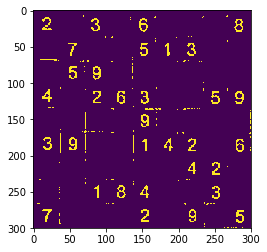

In [123]:
def draw_grid_mask(image):
    grid_mask = np.zeros( (300,300),np.uint8)
    kernel = np.ones((6,1),np.uint8)
    vert = cv2.erode(image,kernel, iterations = 1)
    ind, contours, hierarchy = cv2.findContours(vert,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        if float(w)/h < 0.1:
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            cv2.fillPoly(grid_mask, pts =[box], color=255)

    kernel = np.ones((1,6),np.uint8)
    horiz = cv2.erode(image,kernel,iterations = 1)
    ind, contours, hierarchy = cv2.findContours(horiz,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        if float(w)/h > 10:
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            cv2.fillPoly(grid_mask, pts =[box], color=255)
    kernel = np.ones((2,2),np.uint8)
    return cv2.dilate(grid_mask,kernel)

e1 = cv2.getTickCount()

grid_mask = draw_grid_mask(sudoku)
without_grid = cv2.subtract(sudoku, grid_mask) 

e2 = cv2.getTickCount()
time = (e2 - e1)/ cv2.getTickFrequency()

print(time)
plt.figure()
plt.imshow(without_grid)

Looking for contours(== digits) in sudoku

In [124]:
e1 = cv2.getTickCount()

sudoku_matrix = [[ 0 for x in range(0,9)] for x in range(0,9)]

ind, contours, hierarchy = cv2.findContours(without_grid,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea)

e2 = cv2.getTickCount()
time = (e2 - e1)/ cv2.getTickFrequency()

print(time)

0.003954539


Using model to predict number from contours(== digits) we have just found

In [125]:
def onMatrix(x, y, w, h):
    center = ((2*x+w)/2,(2*y+h)/2)
    cord = tuple((map(lambda x : int(x/30.5 + 0.4) - 1, center)))
    cord = tuple((map(lambda x : 0 if x < 0 else x , cord)))
    return tuple((map(lambda x : 8 if x > 8 else x , cord)))


e1 = cv2.getTickCount()

for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    if float(w)/h > 0.3 and float(w)/h < 1.2 and w*h > 50:
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        i, j = onMatrix(x, y, w, h)
        symbol = sudoku[y:y+h, x:x+h]
        symbol = cv2.resize(symbol, (30, 30)) 
        symbol = cv2.bitwise_not(symbol)
        sudoku_matrix[j][i] = model.predict(symbol)

e2 = cv2.getTickCount()
time = (e2 - e1)/ cv2.getTickFrequency()

def print_field(field):
    if not field:
        print("no Solution")
        return
    N = 9
    for i in range(N):
        for j in range(N):
            cell = field[i][j]
            if cell == 0 or isinstance(cell, set):
                print('.', end="")
            else:
                print(cell, end="")
            if (j + 1) % 3 == 0 and j < 8:
                print(' |', end="")
            if j != 8:
                print(' ', end="")
        print('')
        if (i + 1) % 3 == 0 and i < 8:
            print("- - - + - - - + - - -")

print(time)
print_field(sudoku_matrix)

0.223747098
2 . 3 | . 6 . | . . 8
. 7 . | . 5 1 | 3 . .
. 5 9 | . . . | . . .
- - - + - - - + - - -
4 . 2 | 6 3 . | . 5 9
. . . | . 9 . | . . .
3 9 . | . 1 4 | 2 . 6
- - - + - - - + - - -
. . . | . . . | 4 2 .
. . 1 | 8 4 . | . 3 .
7 . . | . 2 . | 9 . 5
